### Import library

In [16]:
import os
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation,RandomCrop, RandomContrast, Resizing,RandomZoom
import os
%matplotlib inline
np.random.seed(1)
import numpy as np
np.random.seed(5) 
import tensorflow as tf
#tf.set_random_seed(2)
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import keras
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator



### Set up directory and check GPU

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!pwd

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive


In [3]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.8.0
/device:GPU:0
Num GPUs Available:  1


- To make it easier for training given I have a limited GPU and RAM acess, I created subfolders using 87000 images, and I put 2700 images for testing in a folder, and 21600 images for training and validaion in a different folder. However, later I decided only to use 10368 images for training. Here I am acessing the already created folders.

In [4]:
data_list = os.listdir('/content/drive/My Drive/Sign_Language/Dataset_2/ASL_test') 
train_dir = '/content/drive/My Drive/Sign_Language/Dataset_2/final/final_train/'
test_dir='/content/drive/My Drive/Sign_Language/Dataset_2/final/final_final_test/'

In [5]:
directory_train= Path(train_dir)
image_paths = list(directory_train.glob(r'**/*.jpg'))
directory_test= Path(test_dir)
test_paths = list(directory_test.glob(r'**/*.jpg'))

#### Create a data frame to load images in batch

In [6]:
def preprocess_image(path):
    labels = [str(path[i]).split("/")[-2] \
              for i in range(len(path))]
    image_path = pd.Series(path, name='image_path').astype(str)
    labels = pd.Series(labels, name='image_label')
    df = pd.concat([image_path, labels], axis=1)
    # This huffle the DataFrame and reset index
    image_data_frame = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return image_data_frame
image_data_frame = preprocess_image(image_paths)
print('The number of train images in the ASL:', image_data_frame.shape[0])
print("")
print(' The total number of labels is:', len(image_data_frame.image_label.unique()))
print("")

The number of train images in the ASL: 21600

 The total number of labels is: 27



In [7]:
image_data_frame.head(5)

,image_path,image_label
0,/content/drive/My Drive/Sign_Language/Dataset_...,L
1,/content/drive/My Drive/Sign_Language/Dataset_...,D
2,/content/drive/My Drive/Sign_Language/Dataset_...,U
3,/content/drive/My Drive/Sign_Language/Dataset_...,P
4,/content/drive/My Drive/Sign_Language/Dataset_...,M


In [8]:
df_test = preprocess_image(test_paths)
print('The number of test images in the ASL dataset II is:', df_test.shape[0])
print("")
print(' The total number of labels is:', len(df_test.image_label.unique()))

The number of test images in the ASL dataset II is: 2700

 The total number of labels is: 27


Display sample images from training

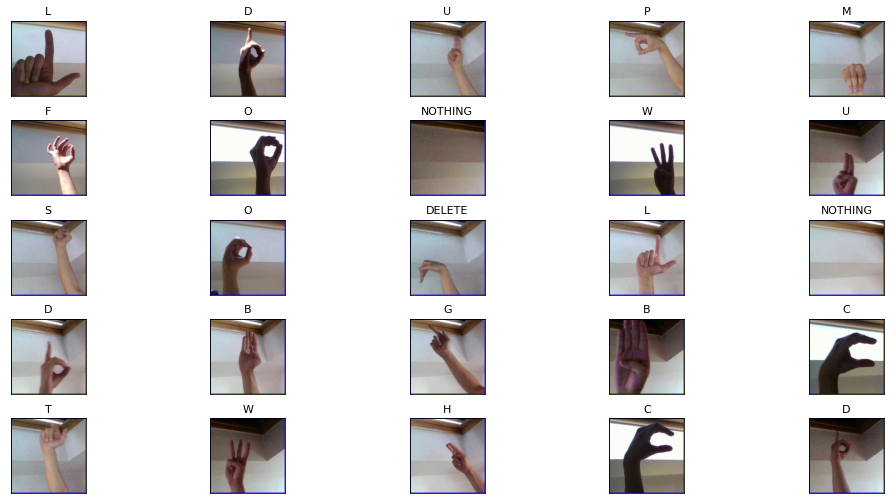

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_data_frame.image_path[i]))
    ax.set_title(image_data_frame.image_label[i], fontsize = 11)
plt.tight_layout(pad=0.7)
plt.show()

- Given, I have 87000 images and the images are colored and have high resolution, I am going to use only a subset of it which is 10368 for training, 1036 for validation, and 2700 for testing.

In [10]:
# Split into training and test datasets
train_df, _ = train_test_split(image_data_frame.sample(frac = 0.6), test_size=0.2, random_state=0)
print(train_df.shape)


(10368, 2)


### Progressive image loading

In [12]:
image_size=(200,200)
num_class=len(data_list)
batch_size=64
train_datagen=ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=1.0/255.0,
    preprocessing_function=None, data_format=None, validation_split=0.1, dtype=None
)

test_datagen=ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=1/255,
    preprocessing_function=None, data_format=None, validation_split=0, dtype=None
)
train_data = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='image_label',
        target_size=image_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=0,
        subset='training'
    )
val_data = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='image_label',
        target_size=image_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=0,
        subset='validation')
test_data = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        x_col='image_path',
        y_col='image_label',
        target_size=image_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )

Found 9332 validated image filenames belonging to 27 classes.
Found 1036 validated image filenames belonging to 27 classes.
Found 2700 validated image filenames belonging to 27 classes.


-  Build Sign_LanguageNet

In [15]:
#adapted from https://www.tensorflow.org/tutorials/images/data_augmentation
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x


def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()


class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

def random_change_bright_img(x):
    return tf.image.random_brightness(x, 0.2)

def random_change_brightness():
    return layers.Lambda(lambda x: random_change_bright_img(x))

random_change_brightness = random_change_brightness()


class RandomBrightness(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return random_change_brightness (x)

In [ ]:
def data_augmenter():
    '''
    Sequential model composed of 2 layers
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.1)) 
    return data_augmentation
def data_augmenter2():
    '''
    Sequential model composed of 3 layers
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal_and_vertical"))
    data_augmentation.add(RandomBrightness())
    data_augmentation.add(RandomRotation(0.2)) 

    return data_augmentation

def data_augmenter3():
    '''
    Sequential model composed of 3 layers
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomRotation(0.3)) 
    data_augmentation.add(RandomBrightness())
    data_augmentation.add(RandomContrast(0.2))
    return data_augmentation
def data_augmenter4():
    '''
    Sequential model composed of 4 layers
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.4)) 
    data_augmentation.add(RandomBrightness())
    data_augmentation.add(RandomContrast(0.2))
    data_augmentation.add(RandomInvert())

    return data_augmentation

def data_augmenter5():
    '''
    Sequential model composed of 2 layers
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2)) 
    data_augmentation.add(RandomBrightness())
    data_augmentation.add(RandomCrop(20,20))
    data_augmentation.add(Resizing(28, 28, interpolation='bilinear', crop_to_aspect_ratio=True)) #resize to 28 x 28

    return data_augmentation

In [13]:
def Sign_LanguageNet_identity_block(X, kernel_size, train_filters, training=True, initializer="HeNormal"):
    filter_1, filter_2, filter_3 = train_filters # these are filters
    residual = X
    #here let's define the conv blocks
    X = Conv2D(filters = filter_1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    X = Activation('relu')(X)
    # this is the second CONV block
    X = Conv2D(filters = filter_2, kernel_size = kernel_size,strides = (1, 1),padding='same',kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    # this is the third CONV block
    X = Conv2D(filters = filter_3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    # let's add the residue to X   
    X = Add()([residual,X])
    # finally let's pass it to an activation fucntion- Relu
    X = Activation('relu')(X)
    return X
def Sign_LanguageNet_convolutional_block(X, kernel, train_filters, stride = 2, training=True, initializer="HeNormal"):
    filter_1, filter_2, filter_3 = train_filters # these are filters
    #temporary/shortcut
    X_temp = X
    # First component
    X = Conv2D(filters = filter_1, kernel_size = 1, strides = (stride, stride), padding='valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    # this is the second CONV block
    X = Conv2D(filters = filter_2, kernel_size = kernel,strides = (1, 1),padding='same',kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    # this is the third CONV block
    X = Conv2D(filters = filter_3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    #This is a skip path
    X_temp = Conv2D(filters = filter_3, kernel_size = 1, strides = (stride, stride), padding='valid', kernel_initializer = initializer)(X_temp)
    X_temp = BatchNormalization(axis = 3)(X_temp, training=training)
    # let's add the residue to X_temp  
    X = Add()([X, X_temp])
    # finally let's pass it to an activation fucntion- Relu
    X = Activation('relu')(X)
    return X
# Now, let's define the main model
def Sign_LanguageNet(input_shape = (200, 200, 3), classes = 27):
    input = Input(input_shape)
    #This is for augumnetatation
    # X=data_augmenter3()(input) for data augumentation
    X = ZeroPadding2D((7,7))(input)   # Zero-Padding
    X = Conv2D(64, (5, 5), strides = (2, 2), kernel_initializer = "HeNormal")(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    X = Sign_LanguageNet_convolutional_block(X, 3,[64, 64, 256], stride = 1)
    X = Sign_LanguageNet_identity_block(X, 3, [64, 64, 256])
    X = Sign_LanguageNet_identity_block(X, 3, [64, 64, 256])
    X = Sign_LanguageNet_identity_block(X, 3, [64, 64, 256])
    X = Sign_LanguageNet_identity_block(X, 3, [64, 64, 256])
    X = Sign_LanguageNet_convolutional_block(X, 3,[128,128,512], stride = 2)
    X = Sign_LanguageNet_identity_block(X, 3,  [128,128,512])
    X = Sign_LanguageNet_identity_block(X, 3,  [128,128,512])
    X = Sign_LanguageNet_identity_block(X, 3,  [128,128,512])
    X = Sign_LanguageNet_identity_block(X, 3,  [128,128,512])
    X = Sign_LanguageNet_convolutional_block(X, 3,[256, 256, 1024], stride = 2)
    X = Sign_LanguageNet_identity_block(X, 3, [256, 256, 1024])
    X = Sign_LanguageNet_identity_block(X, 3, [256, 256, 1024])
    X = Sign_LanguageNet_identity_block(X, 3, [256, 256, 1024])
    X = Sign_LanguageNet_identity_block(X, 3, [256, 256, 1024])
    X = Sign_LanguageNet_identity_block(X, 3, [256, 256, 1024])
    X = Sign_LanguageNet_identity_block(X, 3, [256, 256, 1024])
    X = Sign_LanguageNet_convolutional_block(X, 3, [512, 512, 2048], stride = 2)
    X = Sign_LanguageNet_identity_block(X, 3, [512, 512, 2048])
    X = Sign_LanguageNet_identity_block(X, 3, [512, 512, 2048])
    X = Sign_LanguageNet_identity_block(X, 3, [512, 512, 2048])
    X = AveragePooling2D((2, 2))(X) ## now, lets add a pooling layer
    X = Flatten()(X)
    X= Dense(128, activation='relu',kernel_initializer = "HeNormal")(X)
    X=Dropout(0.35)(X)
    X= Dense(64, activation='relu',kernel_initializer = "HeNormal")(X)
    X= Dropout(0.4)(X)
    X = Dense(classes, activation='softmax', kernel_initializer = "HeNormal")(X)
    model = Model(inputs = input, outputs = X)
    return model

- Model summary

In [14]:
model = Sign_LanguageNet(input_shape = (200, 200, 3), classes = 27)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 214, 214, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 105, 105, 64  4864        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

### Compile and fit the model


In [ ]:
### Adam
adam=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
## RMSprop
rms=tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07)
## SGD
SGD=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
)
### SparseCategoricalCrossentropy Loss
loss=keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(
    loss=loss,
    optimizer=adam,
    metrics=["accuracy"])

In [ ]:
#Training the CNN model
history = model.fit(train_data,batch_size=64, validation_data=val_data,epochs=10,verbose=0)

- Loss and Accuracy plot

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')
plt.savefig("Train Accuracy")

In [ ]:
train_loss, train_acc = model.evaluate(train_data)
test_loss, test_acc = model.evaluate(test_data, verbose=1)

- Prediction

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
pred = probability_model.predict(test_data)
pred = np.argmax(pred,axis=-1)
# This maps the label
labels = (test_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_class = [labels[k] for k in pred]
y_test = list(df_test.image_label)

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

cm = metrics.confusion_matrix(y_test, pred_class)
print(metrics.classification_report(y_test, pred_class))

In [ ]:
# code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# compute confusion matrix
class_labels = list(test_data.class_indices.keys()) 
cnf_matrix = confusion_matrix(y_test,pred_class)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(24, 9))
plot_confusion_matrix(cnf_matrix, classes=class_labels,title='Confusion matrix')
plt.show()